# Vehicle Insurance Claim EDA
This is an exploratory analysis of vehicle insurance claim data. Each row in this dataset represents an individual insurace claim.
In this analysis, I will look for interesting patterns and insights in the data set. Ultimately, the goal is to predict whether a claim is fraud (FraudFound_P) or not based on other variables, but in this analysis, I will only be taking the beginning steps of data exploaration. Some questions that I would like to explore in this analysis are: 
* Who files vehicle insurance claims?
* When are these claims most likely to be filed?
<br /> The first step is to import the appropriate packages for this analysis.

In [1]:
import pandas as pd #
pd.plotting.register_matplotlib_converters()
import numpy as np  #linear algebra and transformations
import seaborn as sns  #visualization
import matplotlib.pyplot as plt #visualization
%matplotlib inline

Read in the data using pandas.

In [2]:
file_path = "../input/vehicle-claim-fraud-detection/fraud_oracle.csv"
ICD = pd.read_csv(file_path)

Get an idea of the size of the dataset. In this case it has 15420 rows and 33 columns.

In [3]:
ICD.shape

(15420, 33)

Take a look at the first 5 rows of the dataset. In this case, we can see that some columns are left out.

In [4]:
ICD.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


List the names of all columns and see what types they are.

In [5]:
ICD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

It is unlikely that I will use all of these columns to answer my questions, but it is good to have an idea of what information is available to use.
<br /> I will begin by answering the question of who files insurance claims, which may also answer who is likely to get into accidents.
For the numeric variables, we can get some quick summary statistics.

In [6]:
ICD.agg(
    {
        'Age': ["min", "max", "median", "mean"],
        'Deductible': ["min", "max", "median", "mean"],
        'DriverRating': ["min", "max", "median", "mean"],
    }
)


,Age,Deductible,DriverRating
min,0.000000,300.00000,1.000000
max,80.000000,700.00000,4.000000
median,38.000000,400.00000,2.000000
mean,39.855707,407.70428,2.487808


This table gives a good quick glance at the averages and range of these three variables. At first glance, seeing a recorded age of 0 seems like an error. I am going to check how many records have an age of 0.

In [7]:
(ICD["Age"] == 0).sum()

320

For predictive modeling, it would make sense to deal with these cases (maybe imputation). However, in this case we will remove them so they don't affect graphs.

In [8]:
ICD_filtered = ICD[ICD['Age'] != 0]

Text(0.5, 1.0, 'Age Distribution')

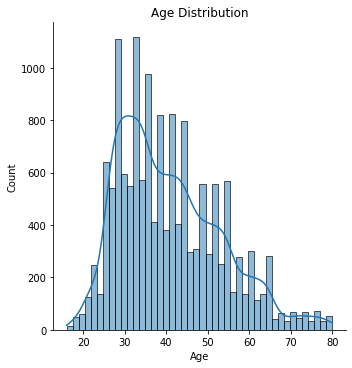

In [9]:
sns.displot(ICD_filtered['Age'], kde = True)
plt.title("Age Distribution")

The age distribution appears to be slightly skewed to the right.

Text(0.5, 1.0, 'Deductible Distribution')

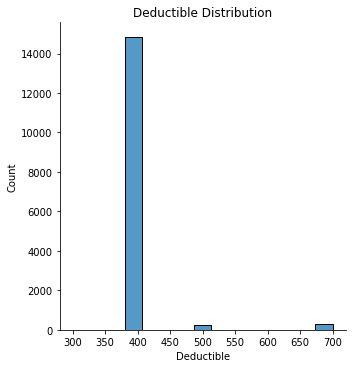

In [10]:
sns.displot(ICD['Deductible'], kde = False)
plt.title("Deductible Distribution")

Note: The vast majority of deductibles are 400 with more rare cases of 500 and 675.

Text(0.5, 1.0, 'DriverRating Distribution')

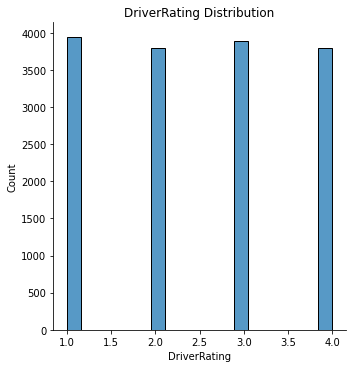

In [11]:
sns.displot(ICD['DriverRating'], kde = False)
plt.title("DriverRating Distribution")


It appears that driver ratings follow a fairly uniform distribution. This is interesting, as you would think that drivers with a higher rating would be in less accidents and file less claims, which is only the case by a close margin. Below are the exact counts for each rating.

In [12]:
ICD.groupby("DriverRating").DriverRating.count()

DriverRating
1    3944
2    3801
3    3884
4    3791
Name: DriverRating, dtype: int64

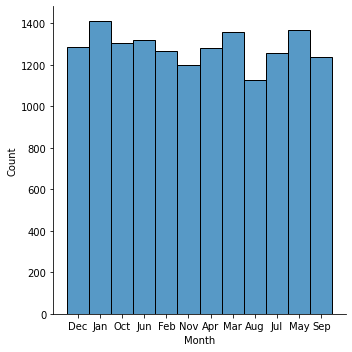

In [13]:
sns.displot(data = ICD['Month'])

The most accidents occur in January, May, and March, respectively. This distribution is almost uniform.

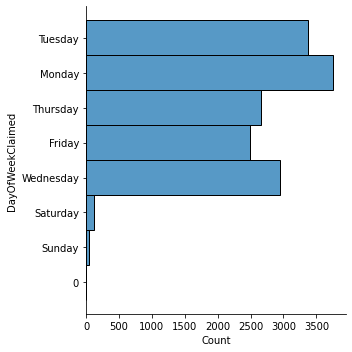

In [14]:
sns.displot(y = ICD['DayOfWeekClaimed'])

Most claims are made on Monday, followed by Tuesday.

In [15]:
n = 10
ICD["Make"].value_counts()[:n]

Pontiac      3837
Toyota       3121
Honda        2801
Mazda        2354
Chevrolet    1681
Accura        472
Ford          450
VW            283
Dodge         109
Saab          108
Name: Make, dtype: int64

The above list shows the 10 most common car makes that are listed on a claim. There appears to be 5 main makes that are in significantly more accidents than other makes. It may be possible to classify these as high risk makes. However, since these makes are very common they may just be more likely to be involved in accidents. 

In [16]:
ICD.AgeOfVehicle.unique()

array(['3 years', '6 years', '7 years', 'more than 7', '5 years', 'new',
       '4 years', '2 years'], dtype=object)

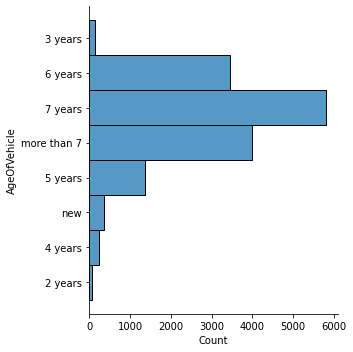

In [17]:
sns.displot(y = ICD["AgeOfVehicle"])

Here we see that most vehicles are 6 years or older.

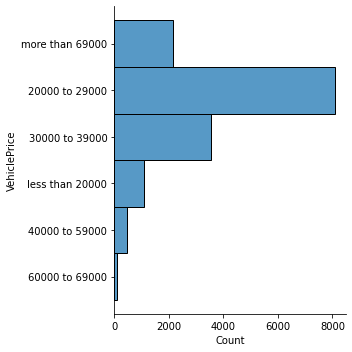

In [18]:
sns.displot(y = ICD["VehiclePrice"])

In [19]:
ICD['FraudFound_P'].mean()

0.05985732814526589

In this dataset, about 6% of rows are classified as fraudulent claims.

In [20]:
ICD['FraudFound_P'] = pd.Categorical(ICD.FraudFound_P)

<AxesSubplot:xlabel='DriverRating', ylabel='Age'>

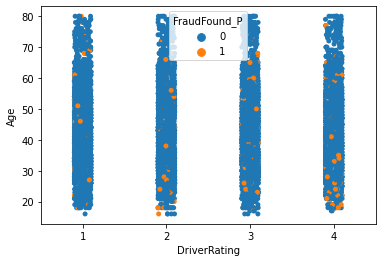

In [21]:
sns.stripplot(x='DriverRating', y= 'Age', hue = 'FraudFound_P', data = ICD_filtered)

This plot shows that fraud appears to be spread throughout all ages and driver ratings.